In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

In [2]:
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"


In [3]:
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [4]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [5]:
k_values = range(2, 13)
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    kmeans.fit(X_train)
    labels = kmeans.labels_
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    
    results.append({"k": k, "inertia": inertia, "silhouette": sil, "CH": ch, "DB": db})

results_df = pd.DataFrame(results)
print(results_df)

     k      inertia  silhouette         CH        DB
0    2  6290.553294    0.070645  45.835056  3.548528
1    3  5872.181746    0.084116  45.597839  2.892671
2    4  5485.651994    0.097166  46.366539  2.544913
3    5  5254.740466    0.086082  42.723269  2.481692
4    6  5072.438114    0.079441  39.580683  2.390039
5    7  4915.715464    0.078621  37.102141  2.266018
6    8  4784.019710    0.077845  34.930152  2.236719
7    9  4671.524077    0.078978  33.010518  2.227642
8   10  4545.151502    0.083193  31.914305  2.174339
9   11  4448.804034    0.080424  30.559527  2.129047
10  12  4378.951624    0.081840  29.021671  2.168859


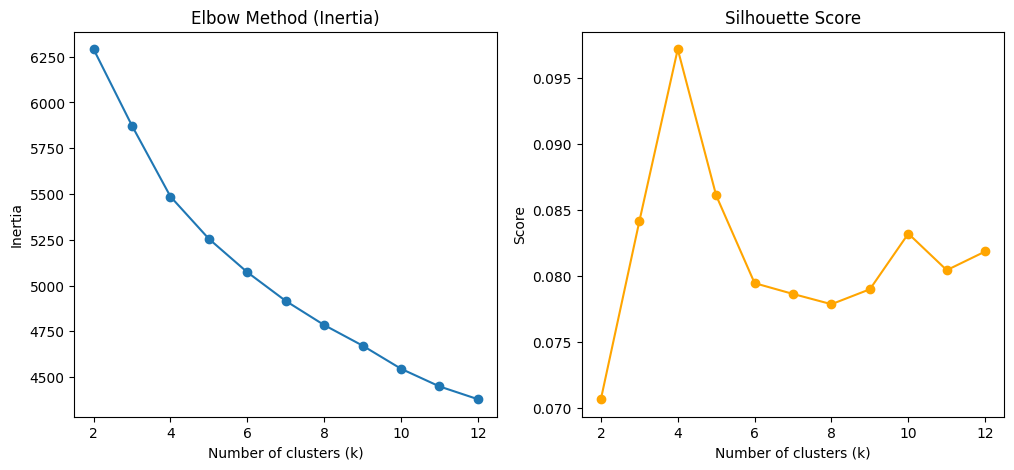

In [6]:


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_df["k"], results_df["inertia"], marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(results_df["k"], results_df["silhouette"], marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.show()

In [7]:
# Step 3.1 — Combine train + validation features for final training
X_trainval = np.vstack([X_train, X_val])

# Step 3.2 — Fit final k-means model
final_kmeans = KMeans(
    n_clusters=6, init="k-means++", n_init=50, max_iter=500, random_state=42
)
final_kmeans.fit(X_trainval)

# Step 3.3 — Assign clusters to each split
train_clusters = final_kmeans.predict(X_train)
val_clusters   = final_kmeans.predict(X_val)
test_clusters  = final_kmeans.predict(X_test)

C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [8]:
K_train=train_df.copy()
K_train['cluster'] = train_clusters
K_val=val_df.copy()
K_val['cluster'] = val_clusters
K_test=test_df.copy()
K_test['cluster'] = test_clusters

In [9]:
def cluster_default_rates(df):
    return df.groupby("cluster")["default_flag"].agg(
        cluster_size="count",
        default_rate="mean"
    ).sort_values("default_rate", ascending=False)

train_cluster_stats = cluster_default_rates(K_train)
val_cluster_stats   = cluster_default_rates(K_val)
test_cluster_stats  = cluster_default_rates(K_test)

print("Train Cluster Default Rates:\n", train_cluster_stats)
print("\nValidation Cluster Default Rates:\n", val_cluster_stats)
print("\nTest Cluster Default Rates:\n", test_cluster_stats)


Train Cluster Default Rates:
          cluster_size  default_rate
cluster                            
0                  83      0.301205
4                 113      0.070796
3                  96      0.062500
2                 104      0.057692
5                 105      0.009524
1                  94      0.000000

Validation Cluster Default Rates:
          cluster_size  default_rate
cluster                            
0                  32      0.312500
4                  30      0.066667
2                  37      0.054054
3                  39      0.051282
1                  32      0.000000
5                  29      0.000000

Test Cluster Default Rates:
          cluster_size  default_rate
cluster                            
0                  29      0.310345
3                  40      0.100000
4                  38      0.052632
5                  28      0.035714
1                  28      0.000000
2                  36      0.000000


In [10]:
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [11]:
x_k_train=K_train.drop(columns=[target_col])
x_k_val=K_val.drop(columns=[target_col])
x_k_test=K_test.drop(columns=[target_col])
y_k_train=K_train[target_col]
y_k_val=K_val[target_col]
y_k_test=K_test[target_col]

In [12]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,      # Let it grow until pure leaves or min_samples constraints
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_k_train, y_k_train)

# Predictions
rf_preds = rf_model.predict(x_k_test)
rf_probs = rf_model.predict_proba(x_k_test)[:, 1]

# Evaluation
print("Random Forest Classification Report:\n", classification_report(y_k_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_k_test, rf_preds))
print("ROC AUC Score:", roc_auc_score(y_k_test, rf_probs))
print("F1 Score:", f1_score(y_k_test, rf_preds))
print("Recall Score:", recall_score(y_k_test, rf_preds))
print("Precision Score:", precision_score(y_k_test, rf_preds))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       183
           1       1.00      0.56      0.72        16

    accuracy                           0.96       199
   macro avg       0.98      0.78      0.85       199
weighted avg       0.97      0.96      0.96       199

Confusion Matrix:
 [[183   0]
 [  7   9]]
ROC AUC Score: 0.9909494535519126
F1 Score: 0.72
Recall Score: 0.5625
Precision Score: 1.0


In [13]:
#get the threshold for the best f1 score
precision, recall, thresholds = precision_recall_curve(y_k_test, rf_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_index]
print("Best F1 Score Threshold:", best_f1_threshold)
# Apply the best threshold to get final predictions
rf_final_preds = (rf_probs >= best_f1_threshold).astype(int)
# Final evaluation with the best threshold
print("Final Random Forest Classification Report with Best F1 Threshold:\n", classification_report(y_k_test, rf_final_preds))


Best F1 Score Threshold: 0.24666666666666667
Final Random Forest Classification Report with Best F1 Threshold:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       183
           1       1.00      0.94      0.97        16

    accuracy                           0.99       199
   macro avg       1.00      0.97      0.98       199
weighted avg       1.00      0.99      0.99       199



In [14]:
fpr, tpr, thresholds = roc_curve(y_k_test, rf_final_preds)
results = {
    "threshold": float(best_f1_threshold),
    "confusion_matrix": confusion_matrix(y_k_test, rf_final_preds).tolist(),
    "accuracy": accuracy_score(y_k_test, rf_final_preds),
    "precision": precision_score(y_k_test, rf_final_preds),
    "recall": recall_score(y_k_test, rf_final_preds),
    "f1_score": f1_score(y_k_test, rf_final_preds),
    "roc_auc": roc_auc_score(y_k_test, rf_final_preds),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results\K-Means_RF_model_results.json", "w") as f:
    json.dump(results, f)

In [15]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(x_k_train, y_k_train)

# Predictions
xgb_preds = xgb_model.predict(x_k_test)
xgb_probs = xgb_model.predict_proba(x_k_test)[:, 1]

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_k_test, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_k_test, xgb_preds))
print("ROC AUC Score:", roc_auc_score(y_k_test, xgb_probs))
print("F1 Score:", f1_score(y_k_test, xgb_preds))
print("Recall Score:", recall_score(y_k_test, xgb_preds))
print("Precision Score:", precision_score(y_k_test, xgb_preds))


C:\Users\ismai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [15:15:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       183
           1       1.00      0.69      0.81        16

    accuracy                           0.97       199
   macro avg       0.99      0.84      0.90       199
weighted avg       0.98      0.97      0.97       199

Confusion Matrix:
 [[183   0]
 [  5  11]]
ROC AUC Score: 0.9996584699453552
F1 Score: 0.8148148148148148
Recall Score: 0.6875
Precision Score: 1.0


In [16]:
fpr, tpr, thresholds = roc_curve(y_k_test, xgb_preds)
# Calculate metrics
results = {
    "threshold": 0.5,  # Default threshold, can be adjusted based on validation set
    "confusion_matrix": confusion_matrix(y_k_test, xgb_preds).tolist(),  # Convert to list for JSON compatibility
    "accuracy": accuracy_score(y_k_test, xgb_preds),
    "precision": precision_score(y_k_test, xgb_preds),
    "recall": recall_score(y_k_test, xgb_preds),
    "f1_score": f1_score(y_k_test, xgb_preds),
    "roc_auc": roc_auc_score(y_k_test, xgb_probs),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),
}

# Save results to a JSON file
with open("Results\K-Means_XGB_model_results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)


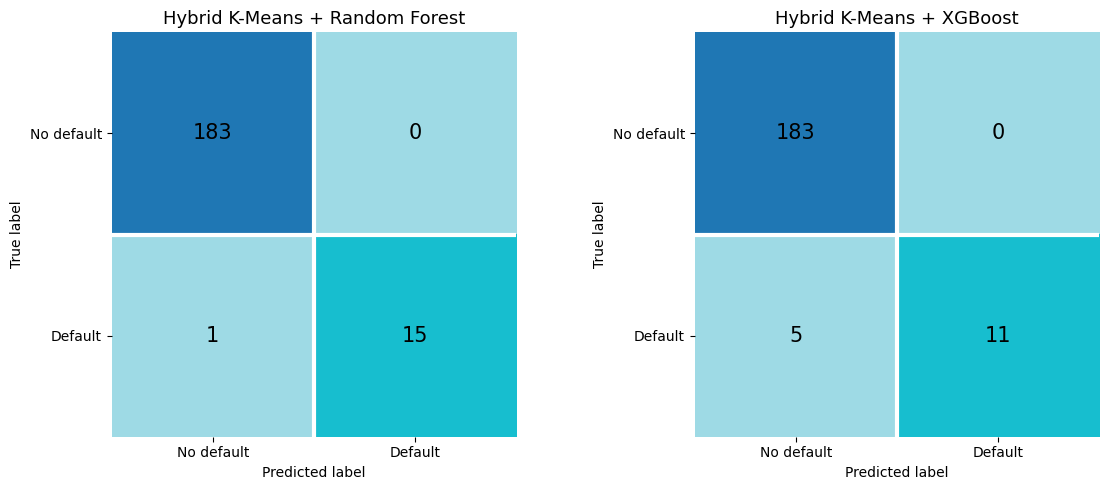

In [17]:

# Compute confusion matrices
cm_rf = confusion_matrix(y_k_test, rf_final_preds, labels=[0, 1])
cm_xgb = confusion_matrix(y_k_test, xgb_preds, labels=[0, 1])

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Function to apply custom style
def plot_cm(cm, ax, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No default', 'Default'])
    disp.plot(values_format='d', cmap='tab20_r', ax=ax, colorbar=False)

    # Make the numbers bigger and black
    for text in disp.text_.ravel():
        text.set_fontsize(15)
        text.set_color('black')

    # Add white grid lines
    n_classes = cm.shape[0]
    for i in range(1, n_classes):
        ax.axhline(i - 0.5, color='white', linewidth=3)
        ax.axvline(i - 0.5, color='white', linewidth=3)

    # Remove outer border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set title
    ax.set_title(title, fontsize=13)

# Plot both matrices
plot_cm(cm_rf, axes[0], "Hybrid K-Means + Random Forest")
plot_cm(cm_xgb, axes[1], "Hybrid K-Means + XGBoost")

plt.tight_layout()
plt.savefig("Plots/Confusion Matricies/K-Means_cm.png")
plt.show()


In [23]:
#get the top features for both models
# Feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
print("Random Forest Feature Importance:\n", feature_importance)


Random Forest Feature Importance:
                            Feature  Importance
0                  bnpl_debt_ratio    0.159343
1             bnpl_usage_frequency    0.133188
2        payment_delinquency_count    0.129076
3         stress_usage_interaction    0.111490
4           financial_stress_score    0.105344
5         credit_limit_utilisation    0.097169
6                          cluster    0.077810
7         debt_accumulation_metric    0.056203
8           impulsive_buying_score    0.034249
9    financial_literacy_assessment    0.033132
10         demographic_risk_factor    0.026239
11        return_dispute_incidents    0.019684
12  credit_card_interest_incidence    0.008607
13        external_repayment_loans    0.008467


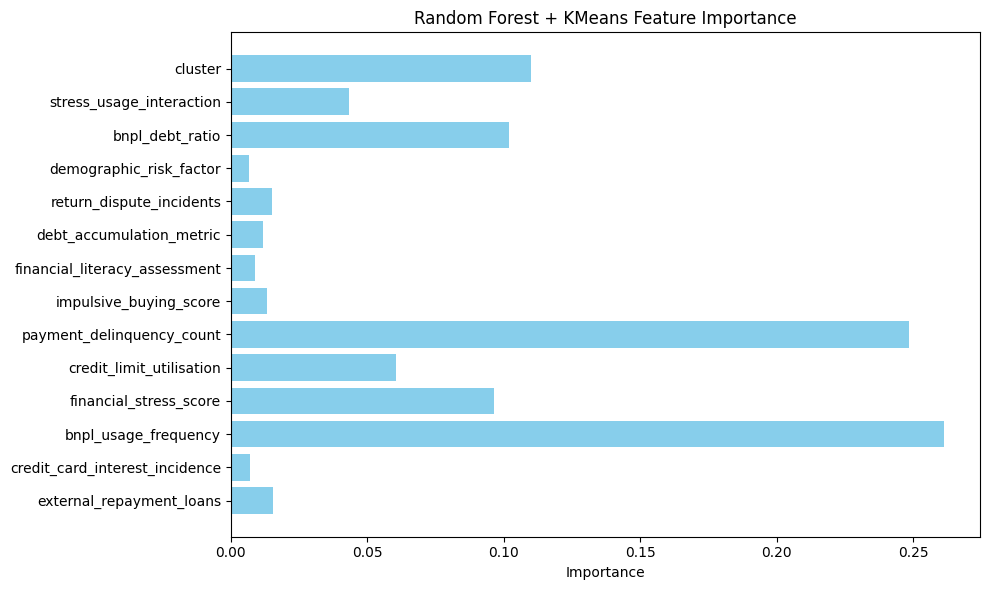

In [24]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Random Forest + KMeans Feature Importance")
plt.tight_layout()


In [20]:
# Feature importance for XGBoost
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
display(feature_importance)

,Feature,Importance
0,bnpl_usage_frequency,0.261352
1,payment_delinquency_count,0.248556
2,cluster,0.110042
3,bnpl_debt_ratio,0.102042
4,financial_stress_score,0.096437
5,credit_limit_utilisation,0.060486
6,stress_usage_interaction,0.043225
7,external_repayment_loans,0.015353
8,return_dispute_incidents,0.015062
9,impulsive_buying_score,0.013172


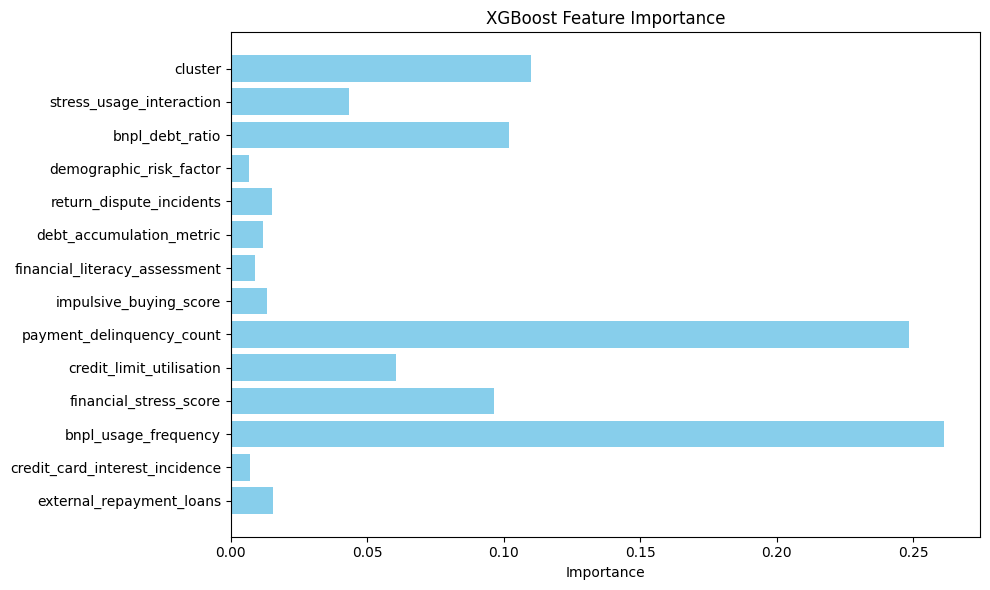

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances = xgb_model.feature_importances_
feature_names = x_k_train.columns
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()